In [1]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
from torch.utils.data import DataLoader, Dataset
import torch
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor
from torchvision import transforms
%matplotlib inline

In [3]:
from PIL import Image
from tqdm.notebook import trange, tqdm
import skimage
from skimage import io
from torchvision.transforms.functional import InterpolationMode as IMode
from time import time

In [4]:
class DatasetSuperResolution(Dataset):

    def __init__(
            self,
            path_to_data: str,
            mode: str = 'train',
            image_size: int = 1080,
            upscale_factor: int = 4

    ):
        super(DatasetSuperResolution, self).__init__()

        self.files = [os.path.join(path_to_data, x) for x in os.listdir(path_to_data)]

        if mode == "train":
            self.hr_transforms = transforms.Compose([
                transforms.RandomCrop(image_size, pad_if_needed = True),
                # transforms.RandomRotation(90)
            ])
        else:
            self.hr_transforms = transforms.CenterCrop(image_size, pad_if_needed = True)

        self.lr_transforms = transforms.Resize(
            image_size // upscale_factor,
            interpolation = IMode.BICUBIC,
            antialias = True
        )

    def __getitem__(self, _index: int) -> [torch.Tensor, torch.Tensor]:
        image = io.imread(self.files[_index])
        image = ToTensor()(image)

        hr_image = self.hr_transforms(image)
        lr_image = self.lr_transforms(hr_image)

        return lr_image, hr_image

    def __len__(self) -> int:
        return len(self.files)

In [15]:
train_set = DatasetSuperResolution('/content/drive/MyDrive/data/sr_data/train_div2k/DIV2K_train_HR/', image_size=384, upscale_factor=4)

In [16]:
dataloader = DataLoader(train_set,
                            batch_size = 1,
                            shuffle = True,
                            num_workers = 2,
                            pin_memory = True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


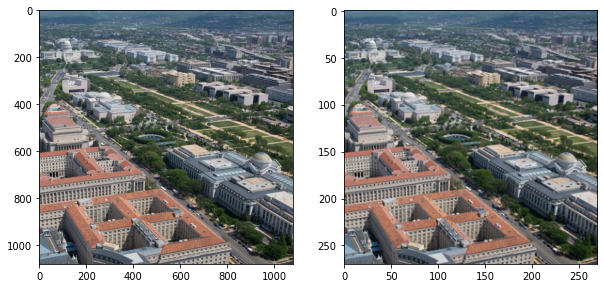

In [ ]:
for x, y in train_dataloader:
  plt.figure(figsize=(10,10))
  for i in range(2):
    plt.subplot(1, 2, i+1)
    if i == 0:
      plt.imshow(y[0].squeeze().permute(1,2,0))
    else:
      plt.imshow(x[0].squeeze().permute(1,2,0))
  break

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
"""
Generator's block of the model
"""
class ConvResBlock(nn.Module):
    """
    This is an implementation of a Residual Convolution Block from the article:
        https://arxiv.org/pdf/1609.04802.pdf
    """

    def __init__(
            self,
            channels: int = 64
    ):
        """
        :param channels: int
            How many channels should be in convolutional blocks
        """
        self.channels = channels
        super(ConvResBlock, self).__init__()

        self.conv_res_block = nn.Sequential(
            nn.Conv2d(
                in_channels = self.channels,
                out_channels = self.channels,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.BatchNorm2d(self.channels),
            nn.PReLU(),
            nn.Conv2d(
                in_channels = self.channels,
                out_channels = self.channels,
                kernel_size = 3,
                stride = 1,
                padding = 1,
                bias = False
            ),
            nn.BatchNorm2d(self.channels)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of Residual Convolution Block
        :param x: torch.Tensor
            Input tensor
        :return: torch.Tensor
            Output tensor
        """
        initial_state = x
        out = self.conv_res_block(x)
        out = torch.add(out, initial_state)
        return out


class Generator(nn.Module):
    """
    Generator implementation of SRGAN from the article:
        https://arxiv.org/pdf/1609.04802.pdf
    """

    def __init__(
            self,
            input_channels: int = 3,
            out_channels: int = 64,
            input_kernel_size: int = 9,
            input_stride: int = 1,
            num_of_res_layers: int = 5
    ):
        super(Generator, self).__init__()

        self.input_channels = input_channels
        self.out_channels = out_channels
        self.input_kernel = input_kernel_size
        self.input_stride = input_stride
        self.first_conv_padding = int(np.ceil((self.input_kernel - self.input_stride) / 2))

        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels = self.input_channels,
                out_channels = self.out_channels,
                kernel_size = self.input_kernel,
                stride = self.input_stride,
                padding = self.first_conv_padding
            ),
            nn.PReLU()
        )

        residual_block = []
        for i in range(num_of_res_layers):
            residual_block.append(ConvResBlock(self.out_channels))
        self.residual_block = nn.Sequential(*residual_block)

        self.conv_2 = nn.Sequential(
            nn.Conv2d(
                in_channels = self.out_channels,
                out_channels = self.out_channels,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.BatchNorm2d(self.out_channels)
        )
        self.conv_3 = nn.Sequential(
            nn.Conv2d(
                in_channels = self.out_channels,
                out_channels = 256,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.PixelShuffle(2),
            nn.PReLU(),
            nn.Conv2d(
                in_channels = self.out_channels,
                out_channels = 256,
                kernel_size = 3,
                stride = 1,
                padding = 1
            ),
            nn.PixelShuffle(2),
            nn.PReLU(),
        )

        self.conv_4 = nn.Conv2d(
            in_channels = self.out_channels,
            out_channels = 3,
            kernel_size = self.input_kernel,
            stride = self.input_stride,
            padding = self.first_conv_padding
        )

        self._initialize_weights()

    def _initialize_weights(self) -> None:
        """
        Weights initialization.
        For convolutional blocks there is "He initialization".
        :return:
            None
        """
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of Generator
        :param x: torch.tensor
            Input Tensor
        :return: torch.Tensor
            Output tensor
        """
        output_1 = self.conv_1(x)
        output_2 = self.residual_block(output_1)
        output = self.conv_2(output_2)
        output = torch.add(output, output_1)
        output = self.conv_3(output)

        output = self.conv_4(output)

        return output

"""
Discriminator's block of the model
"""

class convBlockDiscriminator(nn.Module):
    # '''
    # Block in the discriminator with different stride and in/out channels.
    # '''
  def __init__(self,
               stride_size: int = 1,
               in_channels_size: int = 64,
               out_channels_size: int = 64
               ):
    super(convBlockDiscriminator, self).__init__()
    
    self.conv_block = nn.Sequential(nn.Conv2d(kernel_size=3, in_channels=in_channels_size, out_channels=out_channels_size, stride=stride_size),
                                    nn.BatchNorm2d(out_channels_size), 
                                    nn.LeakyReLU(inplace=True)
                                    )
    
  def forward(self, x: torch.Tensor) -> torch.Tensor:
      return self.conv_block(x)


class Discriminator(nn.Module):

  def __init__(self,
               in_channels_size: int = 3,
               out_channels_size: int = 64,
               layer_size: int = 1000):
    

    super(Discriminator, self).__init__()


    self.conv_start_block = nn.Sequential(nn.Conv2d(kernel_size=3,
                                                    in_channels=in_channels_size,
                                                    out_channels=out_channels_size,
                                                    stride=1),
                                          nn.LeakyReLU(inplace=True))
    
    self.conv_blocks = nn.ModuleList()

    self.conv_block_1 = convBlockDiscriminator(2, 64, 128)
    self.conv_block_2 = convBlockDiscriminator(1, 128, 128)
    self.conv_block_3 = convBlockDiscriminator(2, 128, 256)
    self.conv_block_4 = convBlockDiscriminator(1, 256, 256)
    self.conv_block_5 = convBlockDiscriminator(2, 256, 512)
    self.conv_block_6 = convBlockDiscriminator(1, 512, 512)
    self.conv_block_7 = convBlockDiscriminator(2, 512, 512)
    
    self.linear_block = nn.Sequential(nn.Linear(512 * 21 * 21, layer_size), 
                                      nn.LeakyReLU(inplace=True),
                                      nn.Linear(layer_size, 1))


    self._initialize_weights()


  def _initialize_weights(self) -> None:
        """
        Weights initialization.
        For convolutional blocks there is "He initialization".
        :return:
            None
        """
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                nn.init.kaiming_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
            elif isinstance(module, nn.BatchNorm2d):
                nn.init.constant_(module.weight, 1)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    """
        Forward pass of Discriminator
        :param x: torch.tensor
            Input Tensor
        :return: torch.Tensor
            Output tensor
    """
    out = self.conv_start_block(x)

    out = self.conv_block_1(out)
    out = self.conv_block_2(out)
    out = self.conv_block_3(out)
    out = self.conv_block_4(out)
    out = self.conv_block_5(out)
    out = self.conv_block_6(out)
    out = self.conv_block_7(out)
    
    out = out.flatten(start_dim=1)
    
    out = self.linear_block(out) 

    return F.sigmoid(out)

In [18]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_loss = nn.MSELoss()
discriminator_loss = nn.BCEWithLogitsLoss()

generator_optimizer = torch.optim.AdamW(generator.parameters(),
                                  lr=0.0003, betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.AdamW(discriminator.parameters(),
                                  lr=0.0003, betas=(0.5, 0.999))

In [32]:
def train(
    train_loader,
    generator,
    discriminator,
    gen_loss,
    discr_loss,
    gen_optim,
    discr_optim,
    device,
    epochs: int
):
    generator.train()
    discriminator.train()
    i=0
    for epoch in range(epochs):
        for lr, hr in (train_loader):
            i += 1
            if i == 11:
              return discriminator_sr_loss.item(), generator_loss_tr.item(), total_loss.item(), sr, hr
              break
            lr = lr.to(device)
            hr = hr.to(device)

            real_label = torch.full([lr.size(0), 1], 1.0, dtype = lr.dtype, device = device)
            fake_label = torch.full([lr.size(0), 1], 0.0, dtype = lr.dtype, device = device)

            sr = generator(lr)

            for p in discriminator.parameters():
                p.requires_grad = True

            discr_optim.zero_grad()

            hr_output = discriminator(hr)
            discriminator_hr_loss = discriminator_loss(hr_output, real_label)
            discriminator_hr_loss.backward()

            print(sr.shape)
            sr_output = discriminator(sr.detach())
            discriminator_sr_loss = discriminator_loss(sr_output, fake_label)
            discriminator_sr_loss.backward()

            discr_optim.step()

            for p in discriminator.parameters():
                p.requires_grad = False

            gen_optim.zero_grad()

            output = discriminator(sr)
            generator_loss_tr = generator_loss(output, hr)

            total_loss = generator_loss_tr + discriminator_sr_loss
            generator_loss_tr.backward()
            gen_optim.step()

    return discriminator_sr_loss.item(), generator_loss_tr.item(), total_loss.item(), sr, hr

In [57]:
for x, y in dataloader:
  print(x.shape)
  print(y.shape)
  break

torch.Size([2, 3, 96, 96])
torch.Size([2, 3, 480, 480])


In [33]:
discriminator_sr_loss, generator_loss_tr, total_loss, output, hr = train( dataloader, generator, discriminator, generator_loss, discriminator_loss, generator_optimizer, discriminator_optimizer, device, 1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 3, 384, 384])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])
torch.Size([1, 3, 384, 384])


In [ ]:
discriminator_sr_loss, generator_loss_tr, total_loss, output

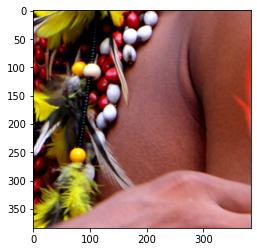

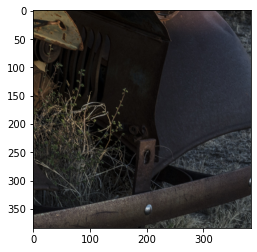

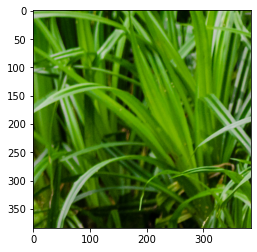

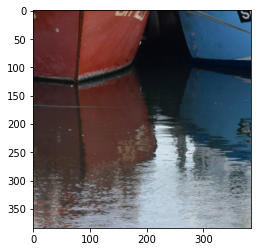

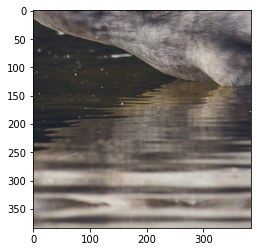

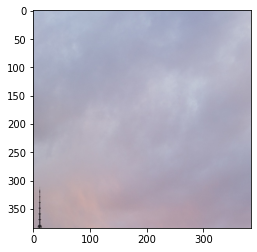

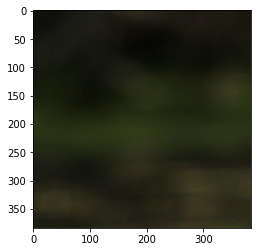

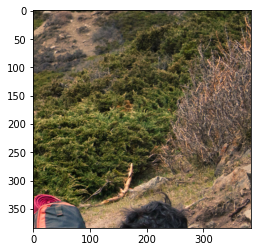

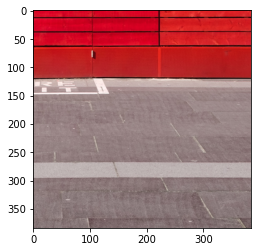

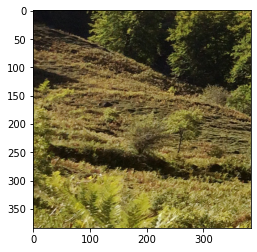

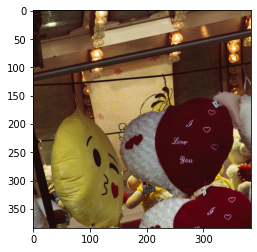

In [31]:
i=0
for x, y in dataloader:
  if i == 11:
    break
  plt.figure()
  plt.imshow(y.squeeze().permute(1, 2, 0).detach().cpu().numpy())
  i+=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


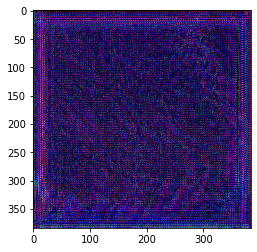

In [34]:
plt.imshow(output.squeeze().permute(1, 2, 0).detach().cpu().numpy())

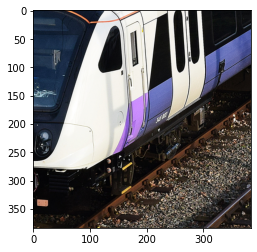

In [35]:
plt.imshow(hr.squeeze().permute(1, 2, 0).detach().cpu().numpy())